In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import plt
import sns
from scipy.spatial.distance import cosine

from data_utils import load_movie_data, load_movie_data_limited

BASE_DIR = Path.cwd().parent.parent
SRC_DIR = BASE_DIR / 'src'
sys.path.insert(0, str(SRC_DIR))

DATA_DIR = str(BASE_DIR / "data")
OUTPUT_DIR = None
N_MOVIES_PER_YEAR = None
RANDOM_SEED = 42
START_YEAR = 19
START_YEAR = 1960


In [2]:
print(f"\nLoading movie data from {DATA_DIR}...")
df = load_movie_data_limited(DATA_DIR, N_MOVIES_PER_YEAR, verbose=False)
print(df.shape)



Loading movie data from /home/martin/GroupDataLiteracy/data...
(210703, 23)


In [3]:
# For each genre, calculate the center in each year and substract from the previous year's center to get the velocity -> absolute value

(375, 22)


In [3]:
def compute_cosine_distance(row):
    if np.all(pd.isna(row['next_avg_embedding'])):
        return np.nan

    return cosine(row['avg_embedding'], row['next_avg_embedding'])

In [4]:
# remove Nan genres
df_cleaned = df.dropna(subset=['genre']).copy()
df_cleaned = df_cleaned[df_cleaned['year'] >= START_YEAR]

# group into single genres
df_cleaned['genre_list'] = df_cleaned['genre'].str.split(', ')
df_exploded = df_cleaned.explode('genre_list')
df_exploded.rename(columns={'genre_list': 'single_genre'}, inplace=True)

# filter to top 10 genres
top_10_genres = df_exploded['single_genre'].value_counts().nlargest(5).index.tolist()
df_exploded = df_exploded[df_exploded['single_genre'].isin(top_10_genres)].copy()

# calculate average embedding per year and genre
grouped_embeddings = df_exploded.groupby(['year', 'single_genre'])['embedding'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
)
group_df = grouped_embeddings.reset_index(name='avg_embedding')
group_df = group_df.sort_values(by=['single_genre', 'year']).copy()

# shift embeddings -1 into "next_avg_embeddings" -> Embedding t and embedding t+1 -> calculate cosine distance
group_df['next_avg_embedding'] = group_df.groupby('single_genre')['avg_embedding'].shift(-1)
group_df['drift_distance'] = group_df.apply(compute_cosine_distance, axis=1)
drift_df = group_df.dropna(subset=['drift_distance']).copy()

# calculate cumulative change per genre
drift_df['cumulative_change'] = drift_df.groupby('single_genre')['drift_distance'].cumsum()

In [5]:
print(drift_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 0 to 319
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                320 non-null    int64  
 1   single_genre        320 non-null    object 
 2   avg_embedding       320 non-null    object 
 3   next_avg_embedding  320 non-null    object 
 4   drift_distance      320 non-null    float64
 5   cumulative_change   320 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.5+ KB
None


In [ ]:
# TODO: heat map of drift distances per year and genre -> per 5 years / 10 years intervals
# TODO: pairwise drift per genre pairs
# TODO: acceleration
# TODO: curvature

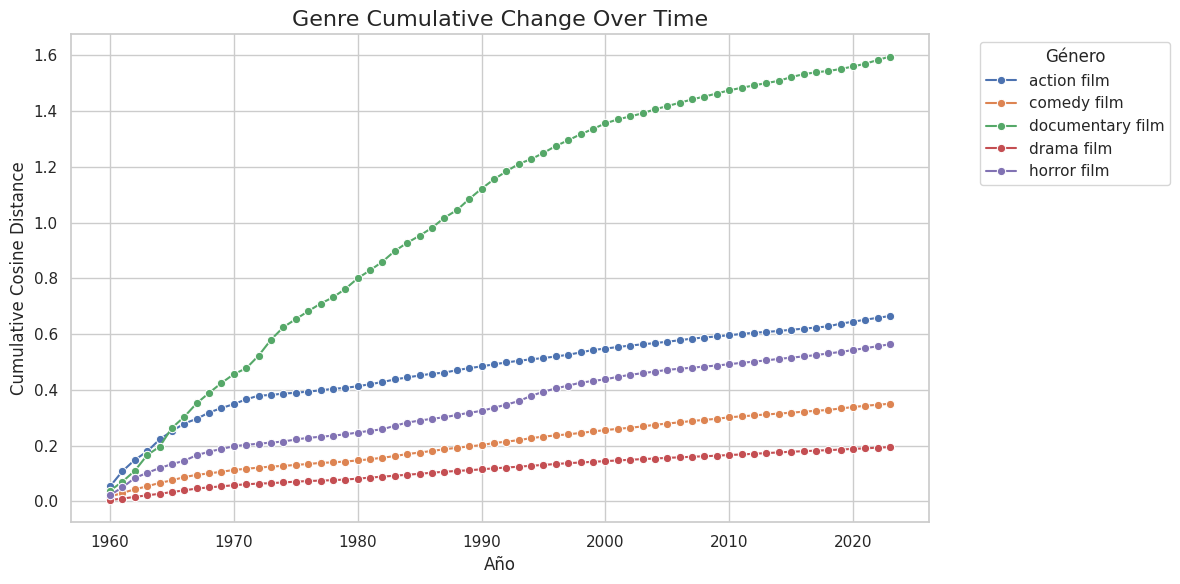

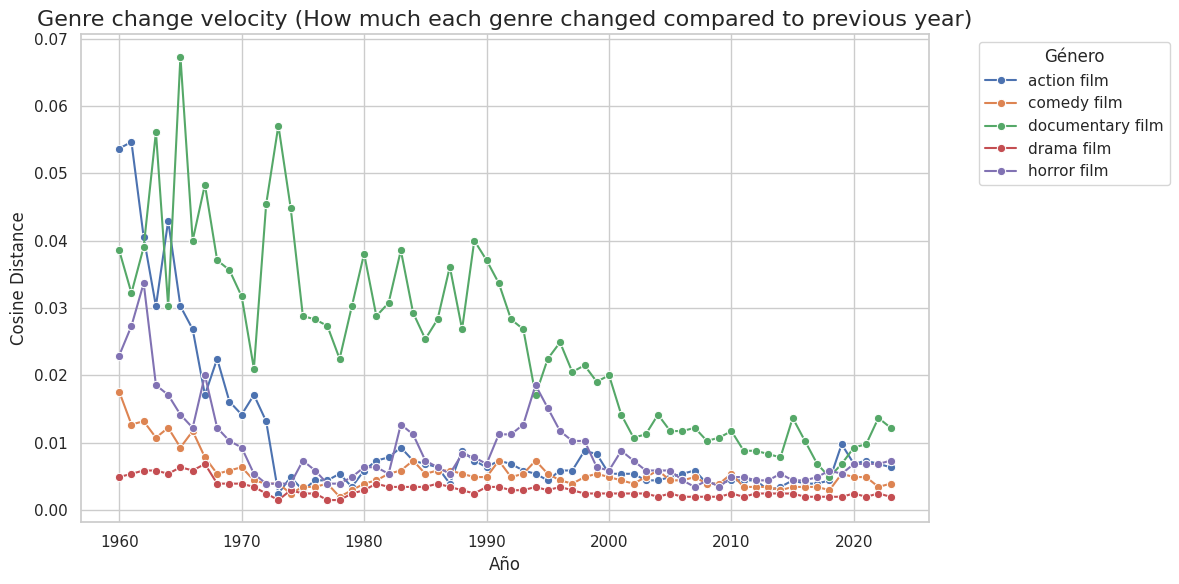

In [7]:
def plot_genre_drift(df, y_column, title, y_label):
    sns.set_theme(style="whitegrid")
    df['year'] = pd.to_numeric(df['year'])

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df,
        x='year',
        y=y_column,
        hue='single_genre',
        marker='o',
        linewidth=1.5
    )
    plt.title(title, fontsize=16)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_genre_drift(
    df=drift_df,
    y_column='cumulative_change',
    title='Genre Cumulative Change Over Time',
    y_label='Cumulative Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='drift_distance',
    title='Genre change velocity (How much each genre changed compared to previous year)',
    y_label='Cosine Distance'
)
